# Microtask 3
---
Produce a listing of repositories, as a table and as a .csv file, with the number of commits authored, issues opened, and pull requests opened, during the last three months, ordered by total number (commits plus issues plus pull requests).

In [1]:
from datetime import datetime
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

import subprocess
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Assuming we have a running instance of Elasticsearch locally at http://localhost:9200

In [2]:
# elasticsearch instance
es = Elasticsearch('http://localhost:9200', verify_certs=False)

In [3]:
# the following repositories will be used
repos = [
    {'org': 'chaoss', 
     'repo': 'grimoirelab-perceval', 
     'index_raw': 'perceval_r', 
     'index_enriched': 'perceval', 
     'index_github_raw': 'perceval_g_r', 
     'index_github_enriched': 'perceval_g'},
    {'org': 'chaoss',
     'repo': 'grimoirelab-kingarthur',
     'index_raw': 'arthur_r',
     'index_enriched': 'arthur',
     'index_github_raw': 'arthur_g_r',
     'index_github_enriched': 'arthur_g'},
    {'org': 'chaoss',
     'repo': 'grimoirelab-sortinghat',
     'index_raw': 'sortinghat_r',
     'index_enriched': 'sortinghat',
     'index_github_raw': 'sortinghat_g_r',
     'index_github_enriched': 'sortinghat_g'},
    {'org': 'chaoss',
     'repo': 'grimoirelab-mordred',
     'index_raw': 'mordred_r',
     'index_enriched': 'mordred',
     'index_github_raw': 'mordred_g_r',
     'index_github_enriched': 'mordred_g'},
    {'org': 'chaoss',
     'repo': 'grimoirelab-manuscripts',
     'index_raw': 'manuscripts_r',
     'index_enriched': 'manuscripts',
     'index_github_raw': 'manuscripts_g_r',
     'index_github_enriched': 'manuscripts_g'}
]
token = ''

Run `p2o.py` to extract data from these repositories

In [ ]:
for repo in repos:
    print(f"Fetching git indices for {repo['repo']}")
    subprocess.run(['p2o.py', '--enrich', '--index', repo['index_raw'], '--index-enrich', repo['index_enriched'], '-e', 'http://localhost:9200', '--no_inc', '--debug', 'git', 'https://github.com/' + repo['org'] + '/' + repo['repo'] + '.git'])
    print(f"Fetching GitHub indices for {repo['repo']}")
    subprocess.run(['p2o.py', '--enrich', '--index', repo['index_github_raw'], '--index-enrich', repo['index_github_enriched'], '-e', 'http://localhost:9200', '--no_inc', '--debug', 'github', repo['org'], repo['repo'], '-t', token, '--sleep-for-rate'])
    print('\n')

Now we need to query the indices and find the number of issues, pull requests and commits in the last 3 months.

In [5]:
df_issues = []
df_pulls = []
df_commits = []
for repo in repos:
    print(repo['repo'])
    # get number of issues and pull requests for each repository in `repos`
    s = Search(using=es, index=repo['index_github_enriched'])
    # filter by time (less than 3 months)
    s = s.filter('range', created_at={'gte' : 'now-3M'})
    # we only need the `item_type` and `created_at`
    s = s.source(['item_type', 'created_at'])
    # sort by date of creation
    s = s.sort({'created_at': {'order': 'asc'}})
    # execute the query
    result = s.execute().to_dict()['hits']['hits']
    # create a DataFrame
    github = pd.DataFrame([ix['_source'] for ix in result])
    # append number of issues for each repository in `df_issues`
    df_issues.append(len(github.where(github.item_type == 'issue').dropna()))
    # append number of pull-requests for each repository in `df_pulls`
    df_pulls.append(len(github.where(github.item_type == 'pull request').dropna()))
    
    # get number of commits for each repository in `repos`
    s = Search(using=es, index=repo['index_enriched'])
    # we only need the `commits_date` field
    s = s.source(['commits_date'])
    # filter by time (less than 3 months)
    s = s.filter('range', commit_date={'gte' : 'now-3M'})
    # append number of commits for each repository in `df_commits`
    df_commits.append(s.execute()['hits']['total'])

grimoirelab-perceval
grimoirelab-kingarthur
grimoirelab-sortinghat
grimoirelab-mordred
grimoirelab-manuscripts


`names` stores the names of the repositories in consideration.

In [6]:
names = [repo['repo'] for repo in repos]

Create a DataFrame `df` by zipping the required lists together.

In [7]:
df = pd.DataFrame(list(zip(names, df_issues, df_pulls, df_commits)))

Calculate the `total` number.

In [8]:
df['total'] = df[1] + df[2] + df[3]

Rename the columns appropriately.

In [15]:
df.rename(columns={0:'name', 1:'issues', 2:'pull_requests', 3:'commits'}, inplace=True)
df.sort_values(by='total', ascending=False)

,name,issues,pull_requests,commits,total
0,grimoirelab-perceval,3,7,260,270
3,grimoirelab-mordred,1,9,107,117
2,grimoirelab-sortinghat,4,6,52,62
1,grimoirelab-kingarthur,1,9,27,37
4,grimoirelab-manuscripts,7,3,7,17


Let's plot the data-frame.

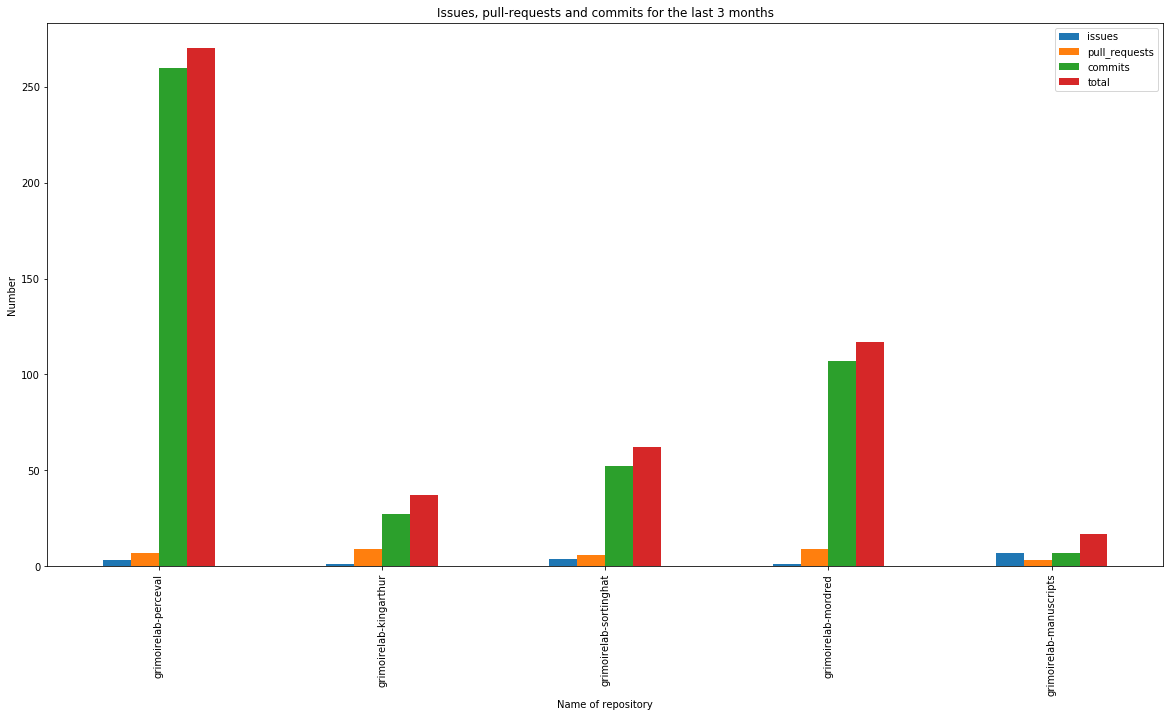

In [16]:
ax = df.plot(x=df.name, kind='bar', figsize=(20, 10))
ax.set_title('Issues, pull-requests and commits for the last 3 months')
ax.set_xlabel('Name of repository')
ax.set_ylabel('Number')
plt.show()

Convert to `.csv` file.

In [17]:
df.to_csv('repo-list.csv')